In [1]:
from data import get_loader, get_data_path
import torch.nn as nn
from torch.utils import data
import numpy as np
from utils.helpers import colorize_mask
import utils.palette as palette
import PIL
import cv2
from tqdm import tqdm
def get_bicycle_hull(label):
    indx = 12
    indx2 = 18
    temp = np.zeros_like(label)
    # temp[label == indx] = 255
    temp[label == indx2] = 200
    temp = np.repeat(temp.reshape((*temp.shape, 1)), 3, axis=2)
    mask = PIL.Image.fromarray(temp.astype(np.uint8))

    contours, hierarchy = cv2.findContours(np.array(mask)[:,:,0], mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    hull_list = []
    for i in range(len(contours)):
        hull = cv2.convexHull(contours[i])
        # print(len(hull))
        #if len(hull) > 10:
        hull_list.append(hull)

    # cont_img = cv2.drawContours(np.array(mask), hull_list, -1, (255,0,0), 1)
    bike_hull = cv2.fillPoly(np.array(mask), hull_list, (255,255,255))

    return bike_hull

def get_bicycle_rider_contour(label):
    indx = 12
    indx2 = 18
    temp = np.zeros_like(label)
    temp[label == indx] = 255
    temp[label == indx2] = 200
    temp = np.repeat(temp.reshape((*temp.shape, 1)), 3, axis=2)
    mask = PIL.Image.fromarray(temp.astype(np.uint8))

    contours, hierarchy = cv2.findContours(np.array(mask)[:,:,0], mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    bike_rider_cont = cv2.fillPoly(np.array(mask), contours, (255,255,255))

    return bike_rider_cont

def get_bicycle_contour(label):
    indx2 = 18
    temp = np.zeros_like(label)
    temp[label == indx2] = 200
    temp = np.repeat(temp.reshape((*temp.shape, 1)), 3, axis=2)
    mask = PIL.Image.fromarray(temp.astype(np.uint8))

    contours, hierarchy = cv2.findContours(np.array(mask)[:,:,0], mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    bike_rider_cont = cv2.fillPoly(np.array(mask), contours, (200,200,200))

    return bike_rider_cont

def fill_bicycle(label):
    bike_hull = get_bicycle_hull(label)
    bike_rider_cont = get_bicycle_rider_contour(label)

    temp = np.zeros_like(label)
    temp[np.logical_and(bike_rider_cont[:,:,0], bike_hull[:,:,0])] = 18
    temp[label == 12] = 12

    # label[temp !=]

    return temp.astype(np.uint8)

def get_iou(data_list, class_num):
    from multiprocessing import Pool
    from utils.metric import ConfusionMatrix

    ConfM = ConfusionMatrix(class_num)
    f = ConfM.generateM
    pool = Pool()
    m_list = pool.map(f, data_list)
    pool.close()
    pool.join()

    for m in m_list:
        ConfM.addM(m)

    aveJ, j_list, M = ConfM.jaccard()
    classes = np.array(("road", "sidewalk",
        "building", "wall", "fence", "pole",
        "traffic_light", "traffic_sign", "vegetation",
        "terrain", "sky", "person", "rider",
        "car", "truck", "bus",
        "train", "motorcycle", "bicycle"))


    for i, iou in enumerate(j_list):
        print('class {:2d} {:12} IU {:.2f}'.format(i, classes[i], 100*j_list[i]))

    return j_list[18]

IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)
input_size = (512,1024)


In [2]:
num_classes = 19
data_loader = get_loader('gta_test')
data_path = get_data_path('gta')
test_dataset = data_loader(data_path, list_path = './data/gta5_list/train.txt', img_size=None, mean=IMG_MEAN)
testloader = data.DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=True)
interp = nn.Upsample(size=(720,1280), mode='bilinear', align_corners=True)
ignore_label = 255

In [3]:
from torchvision import transforms
import torch
class DeNormalize(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, tensor):
        IMG_MEAN = torch.from_numpy(self.mean.copy())
        IMG_MEAN, _ = torch.broadcast_tensors(IMG_MEAN.unsqueeze(1).unsqueeze(2), tensor)
        tensor = tensor+IMG_MEAN
        tensor = (tensor/255).float()
        tensor = torch.flip(tensor,(0,))
        return tensor

    
restore_transform = transforms.Compose([
DeNormalize(IMG_MEAN),
transforms.ToPILImage()])


# find bicycle images

In [4]:
bicycle_indices = []
for i in tqdm(range(len(test_dataset))):
    img, label, _, _, _ = test_dataset[i] #28

    if 18 in np.unique(label):
        bicycle_indices.append(i)
    # if i > 500:
    #     break

np.save("bicycle_images", np.array(bicycle_indices))

100%|██████████| 24966/24966 [49:17<00:00,  8.44it/s]


# load bicycle indices

In [5]:
bicycle_indices = np.load("bicycle_images.npy")


# Plot bicycle images

In [7]:
data_list = []


for index in tqdm(bicycle_indices):
    img, label, _, _, _ = test_dataset[index]
    # image = restore_transform(torch.tensor(img))
    # colorize_mask(label, palette.CityScpates_palette)

    bike_hull = get_bicycle_hull(label)
    bike_rider_cont = get_bicycle_rider_contour(label)
    bike_cont = get_bicycle_contour(label)

    temp = np.zeros_like(label)
    temp[np.logical_and(bike_rider_cont[:,:,0], bike_hull[:,:,0])] = 18
    temp[label == 12] = 12
    temp[np.bool_(bike_cont[:,:,0])] = 18

    mask = temp.astype(np.uint8)

    # ms = colorize_mask(mask, palette.CityScpates_palette)

    label2 = label.copy()
    label2[np.bool_(mask)] = mask[np.bool_(mask)]
    data_list.append([label.flatten().astype(np.uint8), label2.flatten().astype(np.uint8)])

    new_label = colorize_mask(label2, palette.CityScpates_palette)

    s = "00000000" + str(index + 1)
    # new_label.save("/home/erik/datasets/GTA_curated/" + s[-5:] + ".png")

bicycle_iou = get_iou(data_list, 19)

print(f"bicycle iou: {bicycle_iou:.2f}")


100%|██████████| 440/440 [01:08<00:00,  6.39it/s]


In [334]:
# mask = fill_bicycle(label)

bike_hull = get_bicycle_hull(label)
bike_rider_cont = get_bicycle_rider_contour(label)
bike_cont = get_bicycle_contour(label)

temp = np.zeros_like(label)
temp[np.logical_and(bike_rider_cont[:,:,0], bike_hull[:,:,0])] = 18
temp[label == 12] = 12
temp[np.bool_(bike_cont[:,:,0])] = 18

mask = temp.astype(np.uint8)

ms = colorize_mask(mask, palette.CityScpates_palette)

label2 = label.copy()
label2[np.bool_(mask)] = mask[np.bool_(mask)]
new_label = colorize_mask(label2, palette.CityScpates_palette)

s = "00000000" + str(index)
s[-5:]
new_label.save(s[-5:] + ".png")

In [8]:

bicycle_iou = get_iou(data_list, 19)

print(f"bicycle iou: {bicycle_iou:.2f}")

class  0 road         IU 99.81
class  1 sidewalk     IU 99.84
class  2 building     IU 99.98
class  3 wall         IU 99.96
class  4 fence        IU 99.94
class  5 pole         IU 99.99
class  6 traffic_light IU 100.00
class  7 traffic_sign IU 100.00
class  8 vegetation   IU 99.99
class  9 terrain      IU 99.78
class 10 sky          IU 100.00
class 11 person       IU 99.94
class 12 rider        IU 99.11
class 13 car          IU 99.93
class 14 truck        IU 100.00
class 15 bus          IU 100.00
class 16 train        IU 100.00
class 17 motorcycle   IU 100.00
class 18 bicycle      IU 75.82
bicycle iou: 0.76


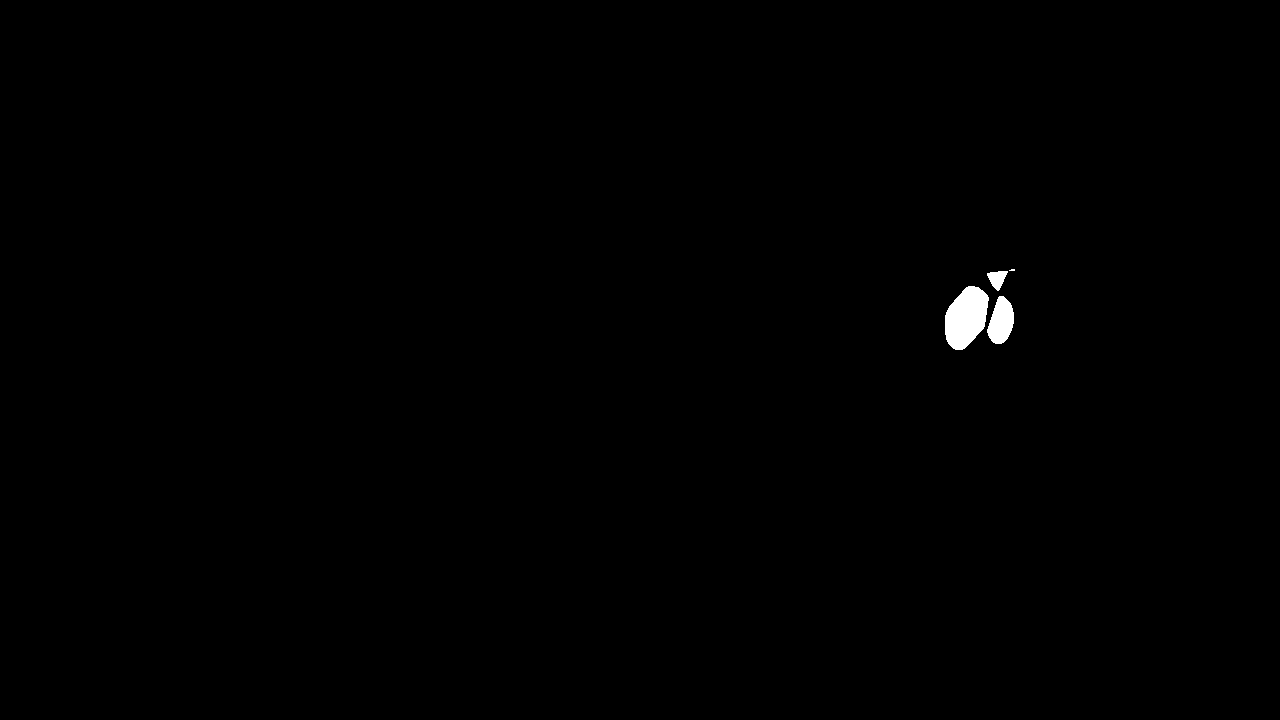

In [226]:
bike_hull.shape
PIL.Image.fromarray(bike_hull.astype(np.uint8))



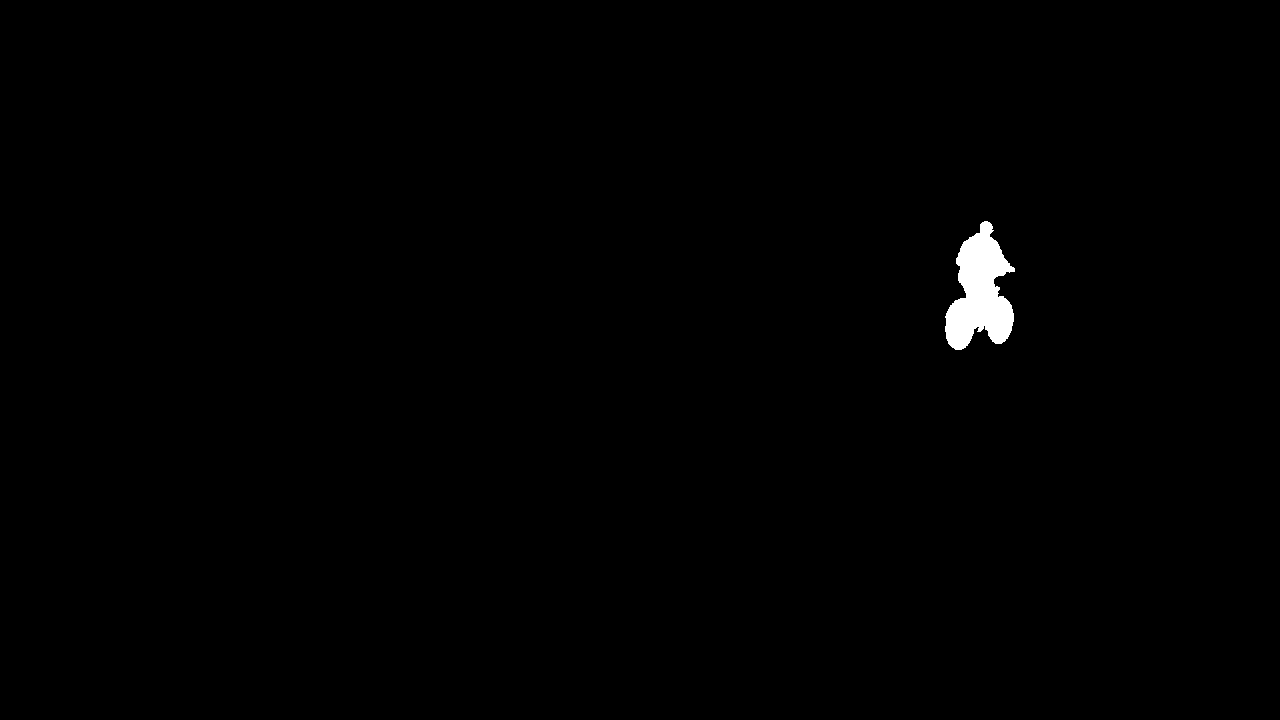

In [227]:

PIL.Image.fromarray(bike_rider_cont.astype(np.uint8))


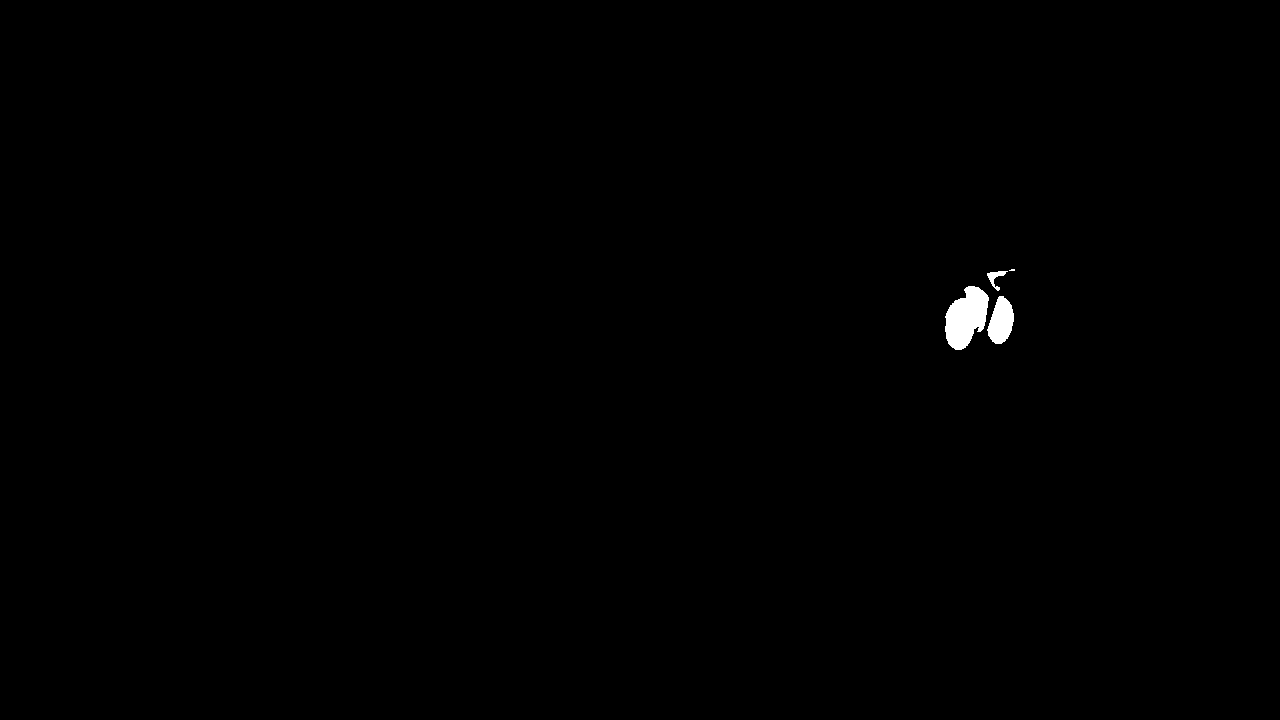

In [228]:
temp = np.zeros_like(label)
temp[np.logical_and(bike_rider_cont[:,:,0], bike_hull[:,:,0])] = 255

PIL.Image.fromarray(temp.astype(np.uint8))


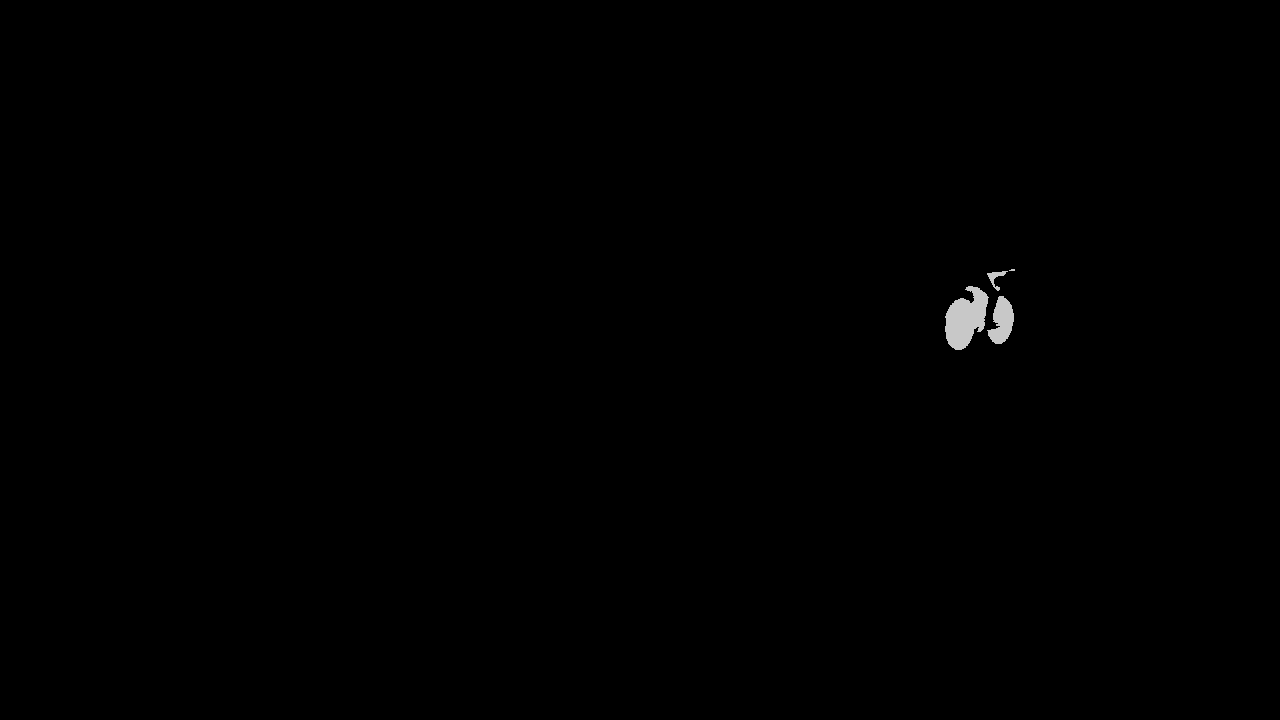

In [229]:

PIL.Image.fromarray(bike_cont.astype(np.uint8))
